# Treating OCR character elision using BERT

Optical Character Recognition, or OCR for short, is the process of taking an image of text and making it machine readable. This technique is dependent on two areas of machine learning: computer vision and natural language processing. One needs a good vision model to identify words and paragraphs, and ideally also a language model to find and clean up errors outputted from the scanned text. Here we will focus on the post-correction stage of the OCR process. 

One issue that can arise within OCR is that a pair of characters are mistaken for another character, because their shapes are similar. This is called character elision. An elision that appears to be quite common is when the computer vision software mistkes `rn` for the letter `m`. This kind of issue seems relatively common within OCR, and could be corrected using NLP concepts and models. 

#### Detecting and correcting elisions

We want our code to accurately correct elisions, but first it needs to detect them. When elision happens there are two possible outcomes: either we have a `legal word error`, or the elision results in nonsense. With a legal error, the eliased word is a valid English word, like when `modern` is interpreted as `modem`. Detecting legal errors would require quite advanced, and expensive, language modelling to score each word in the corpus and determine which ones don't seem to match the context. On the other hand, when the eliased word is not a part of the English language it can be found using a regular spell checker. 

The goal for this project is to explore how using BERT can improve the correction accuracy for eliased text. The idea was inspired by [this article](https://medium.com/states-title/using-nlp-bert-to-improve-ocr-accuracy-385c98ae174c). We will insert synthetic elisions in the Europarl corpus. We then apply a spell checker to detect misspelled words and give a suggested replacement. These spelling suggestions will make up a baseline accuracy. We then explore if, and how much, the correction accuracy can be improved by instead using NLP methods in the correction stage. 


In [3]:
import re
import time
import spacy
import torch
import difflib
import numpy as np
from matplotlib import pyplot as plt
from enchant.checker import SpellChecker 
from transformers import AutoTokenizer, AutoModelForMaskedLM

spell = SpellChecker("en-UK")
nlp = spacy.load('en_core_web_sm')

# Installation instructions for enchant package: pip install pyenchant

# Read in corpus and apply elision

Based on [this article](https://medium.com/states-title/using-nlp-bert-to-improve-ocr-accuracy-385c98ae174c) and suggestions from Richard, we have decided on six elisions to use when corrupting our corpus:

1. rn $\to$ m
2. ol $\to$ d
3. cl $\to$ d
4. vv $\to$ w
5. li $\to$ h
6. nn $\to$ m

When the text is read in, we search for occurences of the six letter pairs to the left. Each time a pair is found it is eliased to the corresponding letter on the right, with a certain elision probability. This is intended to reflect the fact that elision might not occur every time the letter pairs are observed. 

With some words, like `cliff`, it matters in what order we look for the letter pairs. If we find the `cl` and replace it with `d`, the resulting word is `diff`. However if we look for the `li` pair first, the resulting word will be `chff`. To avoid bias in the synthetic elisions, the search order will be randomised for each new document.

In [4]:
# An array containing the elision transformations
elisionArray = []
elisionArray.append(['rn', 'm'])
elisionArray.append(['ol', 'd'])
elisionArray.append(['cl', 'd'])
elisionArray.append(['vv', 'w'])
elisionArray.append(['li', 'h'])
elisionArray.append(['nn', 'm'])
elisionArray = np.array(elisionArray)

## Elision example

We now give an example of how the elisions will be performed, and how we store the results in an accessible way. The function `elision_example` will process a nonsense sentence containing a lot of `rn` and `li`.  Stepping through the sentence, some of the words are read incorrectly. To what extent the line is corrupted depends on the elision probability inputted to the function.

There is a counter for the total number of elisions present in the text, and information about them is stored in a data structure. For each eliased word we save its position in the document, and the original spelling. This is combined to a vector and tupled with the document number in the corpus; this is set to 0 in this case since we only have one line of text. For a single document that has N synthetic elisions, the resulting data structure will look like this:  

> [ ( doc_idx, [ ( word_pos_1, original_word_1 ), ..., ( word_pos_N, original_word_N ) ] ) ]

Another way to access the same information would be to compare the ground truth dataset with the eliased dataset on a line by line basis. Since comparisons will need to be done multiple times, the data structure described above was introduced to save computational time.

In [5]:
def elision_example(elisionArray, elision_prob):

    """
    A function illustrating how the character elision will be handled in this project. 
    Later code follow the same principle, but with more help functions.
    """
    
    # A test sentence that contains a lot of 'rn' and 'li'
    line = "I scorn this little barn with my lilac yarn and delicious fern"
    print("Original line:")
    print(line)
    print('-'*80)

    new_line = line

    # Randomize search order, since some letter pairs overlap 
    elisionArray = np.random.permutation(elisionArray)
    
    # Loop over all pairs and apply elisions
    for pair in elisionArray:
        
        n_errors = 0
        
        for m in re.finditer(pair[0], new_line):

            rd = np.random.rand(1)
            if rd < elision_prob:

                # Note that the position can't be used later since the line changes length!
                print("--> Replaced ", pair[0], " at position ", m.start(), "")

                # Do some line magic
                tmp = list(new_line)
                tmp[m.start()-n_errors:m.end()-n_errors] = "%%"
                new_line = "".join(tmp)
                new_line = new_line.replace("%%", pair[1])
                print(new_line)

                # count number of replacements
                n_errors += 1

    line = list(line.split())
    new_line = list(new_line.split())
    total_errors = 0
    ground_truth = []

    # This will be the index of a document in the corpus
    doc_num = 0     

    # This contains the ground truth for all eliased words
    tmp = []

    # Save location and correct spelling for the corrupted words
    for j in range(len(line)):
        if line[j] != new_line[j]:

            total_errors += 1
            tmp.append((j, line[j]))

    ground_truth.append((doc_num, tmp))
    print('-'*80)
    print("Total elisions: ", total_errors)
    print(ground_truth)

In [6]:
np.random.seed(0)
elision_example(elisionArray, elision_prob = 0.5)
np.random.seed(None)

Original line:
I scorn this little barn with my lilac yarn and delicious fern
--------------------------------------------------------------------------------
--> Replaced  rn  at position  22 
I scorn this little bam with my lilac yarn and delicious fern
--> Replaced  li  at position  13 
I scorn this httle bam with my lilac yarn and delicious fern
--------------------------------------------------------------------------------
Total elisions:  2
[(0, [(3, 'little'), (4, 'barn')])]


## Apply character elision to the Europarl corpus

Here we work with the Europarl corpus, in the hope that the language will be consistent and that there won't be a lot of spelling errors. We read in part of the corpus and apply elisions. Like in the example above, they are inserted randomly and their positions and original spellings are saved. Then a spell checker is applied to detect errors in the eliased corpus. We provide some words and characters for the spellchecker to ignore, and make sure that any candidate misspelled words are not part of a name. 

While spell checking, some words might appear that have no spelling suggestions. Those words tend to be in French or German, since the EU parliament uses these languages occasionally. It's not fair to ask our English spell checker to handle these words, and the purpose here is not to handle multiple different languages. However the impact of this is minimal: in the first 10 000 documents of the corpus, only around 10 contain a word that doesn't have a spelling suggestion. We note how many lines are affected, but the issue is not adressed further. 

Last of all, we apply a train/test split that will be needed for hyperparameter tuning.

### Function definitions

In [7]:
def check_line_errors(line, new_line, total_errors):
    
    """
    Check for errors between gold standard document and eliased document.
    
    Returns: 
        truth: For each word mismatch, note down the word position and the original word. 
        total_errors: A counter for the total number of synthetic elisions in the corpus. 
        
    """

    line = list(line.split())
    new_line = list(new_line.split()) 
    truth = []

    for j in range(len(line)):
        if line[j] != new_line[j]:

            total_errors += 1
            truth.append((j, line[j]))
    
    return truth, total_errors


def apply_elision(line, elision_array, elision_prob):
    
    """
    Apply elision to a line of text. Requires an array with elisions, where letter pairs are in the first column and the 
    resulting letter after elision is in the second column. Whenever one of these letter pairs is observed in the text, 
    it eliased with probability elision_prob.
    
    Returns: 
        new_line: The line of text after elision has (potentially) occured. 
        
    """
    
    # Randomize search order, since some letter pairs overlap 
    elision_array = np.random.permutation(elision_array)
    for elision_pair in elision_array:

        # Count number of times each letter pair has been corrupted (since this changes the line length)
        n_errors = 0 

        for m in re.finditer(elision_pair[0], line):

            rd = np.random.rand(1)
            if rd < elision_prob:

                # Replace the letter pair and convert to a new line
                tmp = list(line)
                tmp[m.start()-n_errors:m.end()-n_errors] = "%%"
                line = "".join(tmp)
                line = line.replace("%%", elision_pair[1])

                # count number of replacements
                n_errors += 1

    return line


def read_data(corpus_file, corpus_encoding, max_lines, elision_array, elision_prob):
    
    """
    Given a file path and encoding, as well as a maximum number of lines, this function reads in a corpus and 
    saves it as a list of documents. It also creates and saves an eliased version of the same corpus. 
        
    Returns:
        ground_truth: The original corpus.
        corrupted_data: The corrupted corpus, where some character elisions have been performed.
        elisions: Information about the elisions. Contains the document indices, line positions, and original spellings.
        total_errors: A counter for the total number of synthetic elisions applied to the corpus.
          
    """
    
    total_errors = 0
    ground_truth = []
    corrupted_data = []
    line_indices = []
    elision_errors = []
    
    with open(corpus_file, encoding = corpus_encoding) as f:
        
        for d, line in enumerate(f):
        
            if d == max_lines:
                break
        
            # Apply elision and keep track of which words have been corrupted
            new_line = apply_elision(line, elision_array, elision_prob)  
            line_truth, total_errors = check_line_errors(line, new_line, total_errors)
            
            if len(line_truth) > 0:
                line_indices.append(d)
                elision_errors.append(line_truth)
                
            # Append original and (potentially) corrupted line
            ground_truth.append(line) 
            corrupted_data.append(new_line)
                
    elisions = (line_indices, elision_errors)
            
    return ground_truth, corrupted_data, elisions, total_errors

In [8]:
def contains_numbers(string):
    
    """
    Check if the given string contains any digits.
    """
    
    return any(char.isdigit() for char in string)


def is_part_of_name(line, word):
    
    """
    Using spacy for NER, we check if a specific word in a line of text appears to be part of a name.
    Check if the word is a subset of the name of a person, nationality, company, or country. 
    
    Returns:
        is_name: a boolean which is True if the word appears to be part of a name.
        
    """
    
    # Apply nlp pipeline, check if this "misspelled word" is a name
    result = nlp(line, disable = ['tagger', 'parser'])
    is_name = False

    for entity in result.ents:
        # If the "misspelled" word is part of the name of a person, country etc - we ignore it
        if entity.label_ in  ["PERSON", "NORP", "GPE", "ORG"] and entity.text.find(word) > -1:
            is_name = True

    return is_name


def identify_spelling_errors(data, ignore):

    """
    Given a dataset and a list of characters to ignore, find misspelled words. The word positions are saved, and
    we also store the spellchecker's suggested spelling. Only words that are not part of a name are considered.
    
    Returns:
        spelling_errors: A data structure containing document indices and line positions for misspelled words.
        spelling_corrected: A data structure containing the same indices as above, but with a spell check applied.
        n_misspelled: A counter for the total number of misspelled words in the text. 
        not_in_english: A list of lines where spelling suggestion was not possible; usually because word is not in English.
        
    """
    
    n_misspelled = 0
    line_indices = []
    spelling_errors = []
    spelling_corrected = []
    not_in_english = []

    for d, line in enumerate(data):

        words = line.split()
        tmp_1 = []
        tmp_2 = []
        
        for i, word in enumerate(words):

            # Some dates and similar are marked as misspelled - ignore words containing numbers!
            if not word in ignore and not contains_numbers(word):
            
                # Apply a spell checker
                if not spell.check(word):
        
                    # Check if the word is part of a name
                    if not is_part_of_name(line, word):

                        try:
                            # Apply a spell correction to the word
                            corrected_word = spell.suggest(word)[0]
                            
                            # Note down word and position
                            tmp_1.append((i, word))
                            tmp_2.append((i, corrected_word))
                            n_misspelled += 1

                        except IndexError:

                            # If no spelling suggestions exist, note the document index. 
                            not_in_english.append(d)
        
        # If spelling errors were found, save the line index and words.
        if len(tmp_1) > 0:
            line_indices.append(d)
            spelling_errors.append(tmp_1)
            spelling_corrected.append(tmp_2)
            
    spelling_errors = (line_indices, spelling_errors)
    spelling_corrected = (line_indices, spelling_corrected)

    return spelling_errors, spelling_corrected, n_misspelled, not_in_english

In [9]:
def match_and_split(indices, datastruct):
    
    """
    Match data structure index component to an array, and keep the overlap.
    """
    
    tmp_idx = []
    tmp_info = []
    
    for i in indices:
        if i in datastruct[0]:
            tmp_idx.append(i)
            j = datastruct[0].index(i)
            tmp_info.append(datastruct[1][j])
            
    return (tmp_idx, tmp_info)

def train_test_split(data, elisions, spell_errors, spell_corrected, train_frac = 0.7):
    
    """
    Split dataset and all related data structures into a training and test part. 
    
    Returns (train, test) where:
        train = (train_data, train_lines, train_elisions, train_errors, train_corrected)
        test = (test_data, test_lines, test_elisions, test_errors, test_corrected)
        
    """
    
    train_len = int(len(data)*train_frac)
    
    line_vec = np.random.permutation(len(data))
    train_lines = np.sort(line_vec[:train_len]).tolist()
    test_lines = np.sort(line_vec[train_len:]).tolist()
    
    train_data = []
    for i in train_lines:
        train_data.append(data[i])

    train_elisions = match_and_split(train_lines, elisions)
    train_errors = match_and_split(train_lines, spell_errors)
    train_corrected = match_and_split(train_lines, spell_corrected)
    
    test_data = []
    for i in test_lines:
        test_data.append(data[i])
        
    test_elisions = match_and_split(test_lines, elisions)
    test_errors = match_and_split(test_lines, spell_errors)
    test_corrected = match_and_split(test_lines, spell_corrected)
            
    return ((train_data, train_lines, train_elisions, train_errors, train_corrected), 
            (test_data, test_lines, test_elisions, test_errors, test_corrected))
    

### Run the code

In [10]:
file = "europarl.txt"
encoding = "utf-8"

elision_prob = 0.5
max_lines = 10000
np.random.seed(None)

# Words and characters for the spellchecker to ignore
ignore = [",", ".", '"', "(", ")", "-", "'", "!", "?", ":", ";", "/", 
          "n't", "'s", "'m", "%", "--", "``", "___LANGCODE___", "''"]

ground_truth, data, elisions, n_elisions = read_data(file, encoding, max_lines, elisionArray, elision_prob)
spell_errors, spell_corrected, n_misspelled, excl_lines = identify_spelling_errors(data, ignore)

# Bundle relevant information
lines = list(range(len(data)))
bundle = (data, lines, elisions, spell_errors, spell_corrected)

print("Number of synthetic errors: ", n_elisions)
print("Number of identified misspelled words: ", n_misspelled)
print("Number of lines where no spelling suggestion could be given:", len(excl_lines))

Number of synthetic errors:  5821
Number of identified misspelled words:  5806
Number of lines where no spelling suggestion could be given: 6


In [11]:
# Apply a train test split
(train, test) = train_test_split(data, elisions, spell_errors, spell_corrected, train_frac = 0.7)
train_data, train_lines, train_elisions, train_errors, train_corrected = train
test_data, test_lines, test_elisions, test_errors, test_corrected = test

# Compute baseline accuracy

As mentioned above, a baseline accuracy is computed based on the spelling suggestions. With inspiration from [this article](https://www.aclweb.org/anthology/I17-1101.pdf), we introduce two word based accuracy metrics: the `detection accuracy` and `correction accuracy`. These are both evaluated on a document level. 

- __Detection accuracy__ shows the proportion of correctly detected errors and nonerrors in the evaluated documents.
- __Correction accuracy__ reflects the ability of the model to accurately correct corrupted strings, without editing non-corrupted strings.

These metrics are calculated as follows:

$$\text{detectionAccuracy} = \frac{(TP + TN + \text{incorrectEdits})}{(TP + TN + FP + FN + \text{incorrectEdits})}$$

$$\text{correctionAccuracy} = \frac{(TP + TN)}{(TP + TN + FP + FN + \text{incorrectEdits})}$$

- __TP__: There is an error on the line, which is corrected successfully.
- __TN__: There is no error on the line, and no correction is made.
- __FP__: There is no error on the line, but the model makes a change anyway.
- __FN__: There is an error on the line, but it's not corrected.
- __incorrectEdit__: There is an error on the line, but the attempted correction is wrong.

It is worth noting that not all documents are the same length. This could possibly be adjusted for in the metrics.

### Function definitions

In [12]:
def compute_accuracy_scores(bundle, verbose = True, corrections = None):
    
    """
    Compute detection and correction accuracy according to definitions above.
    
    Returns:
        det_accuracy: detection accuracy
        corr_accuracy: correction accuracy
    
    """
    
    # Either use provided corrections, or the one in the bundle
    if corrections == None:
        data, _ , elisions, _, corrections = bundle 
    else: 
        data, _ , elisions, _, _ = bundle 
    
    elision_idx = elisions[0]
    elision_words = elisions[1]
    corrected_idx = corrections[0]
    corrected_words = corrections[1]
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    incorrect_edits = 0
    
    # True positives = number of correct changes
    for pos1, idx in enumerate(elision_idx):
        if idx in corrected_idx:
            
            pos2 = corrected_idx.index(idx)
            
            if elision_words[pos1] == corrected_words[pos2]:
                TP += 1
            else:
                incorrect_edits += 1

    # True negatives = number of lines that do not have elision, and that have not been touched by spellchecker
    corpus_size = len(data)
    all_touched_lines = set(corrected_idx) | set(elision_idx)
    TN = corpus_size - len(all_touched_lines)
    
    # False negatives = lines that should have been changed, but were not
    false_neg_lines = set(elision_idx) - set(corrected_idx)
    FN = len(false_neg_lines)
    
    # False positives = there was no elision, but a correction was made anyway
    false_pos_lines = set(corrected_idx) - set(elision_idx)
    FP = len(false_pos_lines)
        
    # Double check that it all adds up
    if FP + FN + TN + TP + incorrect_edits != corpus_size:
        print("ERROR: These scores don't add up to the number of lines!")
        
    # Compute accuracy scores    
    det_accuracy = (TP + TN + incorrect_edits)/corpus_size
    corr_accuracy = (TP + TN)/corpus_size
    
    if verbose == True:
        
        print("True positives: ", TP)  
        print("True negatives: ", TN)
        print("False negatives: ", FN)
        print("False positives: ", FP)
        print("Incorrect edits: ", incorrect_edits)
        print("-"*30)
        print("Detection accuracy: ", np.round(det_accuracy, 4))
        print("Correction accuracy: ", np.round(corr_accuracy, 4))
        print("="*40)
    
    return det_accuracy, corr_accuracy


### Running the code

In [13]:
det_acc_full, corr_acc_full = compute_accuracy_scores(bundle)
det_acc_train, corr_acc_train = compute_accuracy_scores(train)
det_acc_test, corr_acc_test = compute_accuracy_scores(test)

True positives:  738
True negatives:  5580
False negatives:  335
False positives:  294
Incorrect edits:  3053
------------------------------
Detection accuracy:  0.9371
Correction accuracy:  0.6318
True positives:  531
True negatives:  3911
False negatives:  227
False positives:  216
Incorrect edits:  2115
------------------------------
Detection accuracy:  0.9367
Correction accuracy:  0.6346
True positives:  207
True negatives:  1669
False negatives:  108
False positives:  78
Incorrect edits:  938
------------------------------
Detection accuracy:  0.938
Correction accuracy:  0.6253


# Fill in missing words using BERT 

So far we have created synthetic elisions, and attempted to find them using a spellchecker. We now want to correct the identified misspelled words using BERT for masked LM. This is a BERT model with a language modelling head on top, from the Transformers library. 

The following is performed only for the lines with spelling errors: each misspelled word is replaced with the `[MASK]` token, and the BERT tokenizer is applied to the line. We also generate segment tensors, that tell us which parts of the document are in different sentences (this is done by looking for a period in the text). Feeding the tokenized line and the segment information to the BertForMaskedLM model, we can ask it to suggest words that could be hidden behind the `[MASK]` token. When considering these suggestions, the code provides two options:

1. Use the top suggestion, ignoring any information about the misspelled word.
2. Generate a certain number of suggestions, then choose the one that best matches the misspelled word. This is intended to give a suggestion that matches the context, but also uses information about the misspelled word.

Option number 2 has the potential of yielding a higher correction accuracy, depending on the number of suggestions given. To give a more specific example of the two approaches, we consider a sentence in the corpus that contains the word `families`. If elision happens, this word instead becomes `famihes`. The spell checker suggests correcting this to `famished`, which is does not fit into the same context. Bert's top suggestion based on the context is `parents`. However if we ask for more suggestions, and match them against the misspelled word, we correctly end up with `families`.


In [14]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Function definitions

In [15]:
def find_best_suggestion(word, suggestions):
    
    """
    Find the spelling suggestion that best matches a given word.
    """
    
    dict, max = {}, 0
    a = set(suggestions)

    for b in a:

        tmp = difflib.SequenceMatcher(None, word, b).ratio();
        dict[tmp] = b

        if tmp > max:
            max = tmp

    return(dict[max])

In [16]:
def create_segments_tensors(tokenized_text):
    
    """
    Given a line of tokenized text, create segments tensors needed for maskedLM. 
    """
    
    segs = [i for i, e in enumerate(tokenized_text) if e == "."]
    segments_ids=[]
    prev=-1
    for k, s in enumerate(segs):
        segments_ids = segments_ids + [k] * (s-prev)
        prev=s
    segments_ids = segments_ids + [len(segs)] * (len(tokenized_text) - len(segments_ids))
    segments_tensors = torch.tensor([segments_ids])
    
    return segments_ids, segments_tensors


def masked_LM_oneline(tokenizer, model, line, line_info, use_word=False, n_suggestions=None):
    
    """
    Perform masked LM on one line of text and return the top predictions, given a tokenizer and model.
    
    Returns:
        mask_predictions: for each [MASK] token in the line, there is a word suggestion.
        
    """
    
    # Replace misspelled words with MASK token
    split_line = line.split()
    for item in line_info:
        split_line[item[0]] = '[MASK]'
    line = " ".join(split_line)
    
    # Load, train and predict using pre-trained model
    tokenized_text = tokenizer.tokenize(line)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    MASKIDS = [i for i, e in enumerate(tokenized_text) if e == '[MASK]']

    # Create the segments tensors
    segments_ids, segments_tensors = create_segments_tensors(tokenized_text)

    # Predict all tokens
    with torch.no_grad():
        predictions = model(tokens_tensor, segments_tensors)

    # Process and display top prediction at each position
    mask_predictions = []

    if use_word == False:
        
        for mask_idx in MASKIDS:
            word_int = predictions[0][0, mask_idx, :].topk(1).indices.tolist()
            word_text = tokenizer.convert_ids_to_tokens(word_int)        
            mask_predictions.append(word_text[0])
    else:
        
        for k, mask_idx in enumerate(MASKIDS):

            word_int = predictions[0][0, mask_idx, :].topk(n_suggestions).indices.tolist()
            word_text = tokenizer.convert_ids_to_tokens(word_int)
            original_word = line_info[k][1]
            best = find_best_suggestion(original_word, word_text)
            mask_predictions.append(best)
        
    return mask_predictions


def masked_prediction(bundle, tokenizer, model, use_word=False, n_suggestions=5):   
    
    """
    Given a dataset and locations of misspelled words, perform masked prediction to replace the words. 
    Can either use information about the misspelled words, or disregard them entirely.
    
    Returns:
        corrected: a data structure containing BERT corrected words and their locations in the corpus.
        
    """
    
    data, lines, _, spell_errors, _ = bundle 
    corrected = []

    for i in range(len(spell_errors[0])):

        line_idx = spell_errors[0][i]
        line_info = spell_errors[1][i]
        j = lines.index(line_idx)
        line = data[j]           
        
        # Retrieve prediction using masked LM
        preds = masked_LM_oneline(tokenizer, model, line, line_info, use_word, n_suggestions)
        
        # Save the results
        tmp = []
        for j, item in enumerate(line_info):
            idx = item[0]
            tmp.append((idx, preds[j]))

        corrected.append(tmp)
        
    corrected = (spell_errors[0], corrected)
    return corrected

### Corrections using BERT for masked LM

In [29]:
# Completely ignore information about the misspelled word
bert_corrected_1 = masked_prediction(bundle, tokenizer, model, use_word = False)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(bundle, corrections = bert_corrected_1)

# Ask for 5 suggested words, and match them against the misspelled word
bert_corrected_2 = masked_prediction(bundle, tokenizer, model, use_word = True, n_suggestions = 5)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(bundle, corrections = bert_corrected_2)

# Ask for 5 suggested words, and match them against the misspelled word
bert_corrected_3 = masked_prediction(bundle, tokenizer, model, use_word = True, n_suggestions = 10)
det_acc_bert, corr_acc_bert = compute_accuracy_scores(bundle, corrections = bert_corrected_3)

True positives:  331
True negatives:  5580
False negatives:  335
False positives:  294
Incorrect edits:  3460
------------------------------
Detection accuracy:  0.9371
Correction accuracy:  0.5911
True positives:  721
True negatives:  5580
False negatives:  335
False positives:  294
Incorrect edits:  3070
------------------------------
Detection accuracy:  0.9371
Correction accuracy:  0.6301
True positives:  909
True negatives:  5580
False negatives:  335
False positives:  294
Incorrect edits:  2882
------------------------------
Detection accuracy:  0.9371
Correction accuracy:  0.6489


Here we have run the BERT for masked LM on the entire corpus. We note that the detection accuracy is exactly the same for all three runs, and this is also the same as the baseline detection accuracy. This is not surprising since the error detection is performed in the same way for all models. The detection accuracy is quite high (around 93%), which supports our choice of using the spell checker to find elisions. Using more sophisticated methods to improve the detection accuracy would likely demand a lot more computational power, and even then it might be a case of diminishing returns. With the detection accuracy constant, we will henceforth only compare progress using the correction accuracy. There are also more improvements to be made in this area. 

***

From the three results above, we see that accepting more word suggestions from BERT can increase the correction accuracy. Logically, this only affects the number of true positives and incorrect edits. If n_suggestions is chosen optimally, we can convert a maximum amount of incorrect edits into true positives. We will tune n_suggestions on the training part of the corpus, and then see what correction accuracy this gives for the test part of the corpus. 

### Tune n_suggestions on the training data

In [23]:
start_1 = time.time()
corr_acc_vec = []
n_sugg_vec = range(1, 150, 10)

for n_suggestions in n_sugg_vec:
    start_2 = time.time()
    bert_corr = masked_prediction(train, tokenizer, model, use_word = True, n_suggestions = n_suggestions)
    _, acc = compute_accuracy_scores(bundle,  verbose = False, corrections = bert_corr)
    corr_acc_vec.append(acc)
    print("Done with ", n_suggestions, " suggestions. Correction accuracy: ", acc, ". Elapsed time: ", time.time() - start_2)
    
print("Elapsed time: ", time.time() - start_1)

Done with  1  suggestions. Correction accuracy:  0.589 . Elapsed time:  340.81361269950867
Done with  11  suggestions. Correction accuracy:  0.6318 . Elapsed time:  352.20549154281616
Done with  21  suggestions. Correction accuracy:  0.6457 . Elapsed time:  337.28776836395264
Done with  31  suggestions. Correction accuracy:  0.6515 . Elapsed time:  337.46693754196167
Done with  41  suggestions. Correction accuracy:  0.6559 . Elapsed time:  332.2921733856201
Done with  51  suggestions. Correction accuracy:  0.6578 . Elapsed time:  344.25616478919983
Done with  61  suggestions. Correction accuracy:  0.6588 . Elapsed time:  326.5397262573242
Done with  71  suggestions. Correction accuracy:  0.6612 . Elapsed time:  332.3647768497467
Done with  81  suggestions. Correction accuracy:  0.6629 . Elapsed time:  339.96380162239075
Done with  91  suggestions. Correction accuracy:  0.6643 . Elapsed time:  336.81837725639343
Done with  101  suggestions. Correction accuracy:  0.6653 . Elapsed time:  

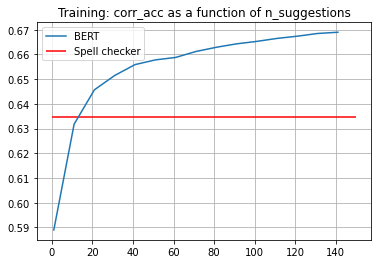

In [28]:
_, corr_acc_train = compute_accuracy_scores(train, verbose = False)

plt.plot(n_sugg_vec, corr_acc_vec, label = "BERT")
plt.title("Training: corr_acc as a function of n_suggestions")
plt.hlines(corr_acc_train, 0, 150, 'r', label = "Spell checker")
plt.legend()
plt.grid(True)
plt.savefig('suggestions_tuning.png')

In [31]:
# Evaluate on the test set!
best_idx = corr_acc_vec.index(max(corr_acc_vec))
best_n_suggestions = n_sugg_vec[best_idx]
print("Optimal number of suggestions: ", best_n_suggestions)

bert_corr = masked_prediction(test, tokenizer, model, use_word = True, n_suggestions = best_n_suggestions)

print("Baseline for the test data")
_, corr_acc_test = compute_accuracy_scores(test, verbose = True)

print("BERT corrections for the test data")
_, acc = compute_accuracy_scores(test, corrections = bert_corr, verbose = True)

Baseline for the test data
True positives:  207
True negatives:  1669
False negatives:  108
False positives:  78
Incorrect edits:  938
------------------------------
Detection accuracy:  0.938
Correction accuracy:  0.6253
BERT corrections for the test data
True positives:  443
True negatives:  1669
False negatives:  108
False positives:  78
Incorrect edits:  702
------------------------------
Detection accuracy:  0.938
Correction accuracy:  0.704


The tuning was performed on a corpus with max_lines = 10000, train_frac = 0.7, and elision_prob = 0.5. We looped over n_suggestions = 1, 11, ..., 141. The highest correction accuracy on the training corpus was found for n_suggestions = 141. In fact, the accuracy appears to keep improving as we increase the number of suggested words. It would be interesting to run the same loop over a bigger part of the corpus, and with smaller steps. However this is unlikely to change the general result: more suggestions give a higher accuracy. 

We notice that already around n_suggestions = 15, the BERT model surpasses the spell checker in accuracy. After this point the accuracy increases steadily with n_suggestions, but does appear to start flattening out when n_suggestions has reached its final value of 141. It's worth noting that the code doesn't take longer to run just because we ask BERT for more suggestions, so it would definitely be interesting to continue with even higher numbers. 

The top suggestions from BERT tend to be quite generic. Quite a high number of context-based suggestions are needed before we find the original word, since these can be quite specialised. If we understand correctly, the Europarl corpus consists of transcripts of the proceedings that have been translated into English. This would mean that the documents come from spoken language, and that there is additional noise from the translation process. There are certainly "nicer" corpora for this kind of task, such as an book written in English - having the same author gives consistency. However, it's possible that the drawbacks can be outweighed by simply letting BERT give more word suggestions. 

### Correction accuracy as a function of elision_prob

In [73]:
def evaluation_pipeline(file, encoding, elisionArray, elision_probs, max_lines, ignore_list, suggestion_vec, verbose = True):
    
    """
    Pipeline for loading in data with different levels of elision probability, and applying the Bert model. 
    
    Returns:  
        corr_acc_vec: list of correction accuracies for different elision_probs and n_suggestions. 
        
    """
    
    start = time.time()
    corr_acc_vec = []
    lines = list(range(max_lines))

    for elision_prob in elision_probs:
    
        start_loop = time.time()
        ground_truth, data, elisions, n_elisions = read_data(file, encoding, max_lines, elisionArray, elision_prob)
        spell_errors, spell_corrected, n_misspelled, excl_lines = identify_spelling_errors(data, ignore_list)
        bundle = (data, lines, elisions, spell_errors, spell_corrected)
        
        if verbose == True:
            
            print("Number of identified misspelled words: ", n_misspelled)
            print("Number of synthetic errors: ", n_elisions)
            print("="*75)

        for n_suggestions in suggestion_vec:   
            
            bert_corrected = masked_prediction(bundle, tokenizer, model, use_word=True, n_suggestions=n_suggestions)
            _, acc = compute_accuracy_scores(bundle, verbose = False, corrections = bert_corrected)    
            corr_acc_vec.append(acc)
            
        print("Done with elision_prob = ", round(elision_prob, 2), " - Elapsed time: ", time.time() - start_loop)
        
    print('='*70)    
    print("Elapsed time: ", time.time() - start)
        
    return corr_acc_vec

In [75]:
elision_probs = np.linspace(0, 1, 10)
n_lines = 2000
suggestion_vec = [1, 75, 150]

corr_vec = evaluation_pipeline(file, encoding, elisionArray, elision_probs, max_lines = n_lines, 
                               ignore_list = ignore, suggestion_vec = suggestion_vec, verbose = False)

step = len(suggestion_vec)
corr_vec_1 = corr_vec[::step]
corr_vec_2 = corr_vec[1::step]
corr_vec_3 = corr_vec[2::step]

Done with elision_prob =  0.0 . Elapsed time:  61.540390729904175
Done with elision_prob =  0.11 . Elapsed time:  144.68026542663574
Done with elision_prob =  0.22 . Elapsed time:  213.4309208393097
Done with elision_prob =  0.33 . Elapsed time:  268.236697435379
Done with elision_prob =  0.44 . Elapsed time:  332.8888580799103
Done with elision_prob =  0.56 . Elapsed time:  365.2755024433136
Done with elision_prob =  0.67 . Elapsed time:  393.7043249607086
Done with elision_prob =  0.78 . Elapsed time:  424.24899649620056
Done with elision_prob =  0.89 . Elapsed time:  456.2612738609314
Done with elision_prob =  1.0 . Elapsed time:  511.0944962501526
Elapsed time:  3171.3637278079987


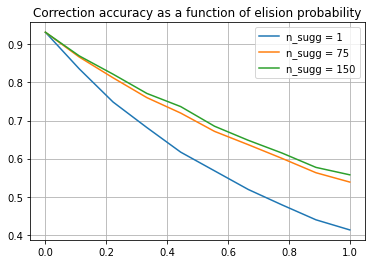

In [76]:
plt.plot(elision_probs, corr_vec_1, label = "n_sugg = " + str(suggestion_vec[0]))
plt.plot(elision_probs, corr_vec_2, label = "n_sugg = " + str(suggestion_vec[1]))
plt.plot(elision_probs, corr_vec_3, label = "n_sugg = " + str(suggestion_vec[2]))
plt.title("Correction accuracy as a function of elision probability")
plt.grid(True)
plt.legend()
plt.savefig('elision_prob.png')

it doesn't start at 1.0 because 
mathematically we can never achieve corr_acc > det_acc; can' correct more errors that we're detecting
there is an upper limit there!

### Distilbert - does this give suggestions in the same way?

In [ ]:
model_name_2 = 'albert-base-v2'
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)
model_2 = AutoModelForMaskedLM.from_pretrained(model_name_2).eval()

In [ ]:
model_name_3 = 'google/electra-small-discriminator'
tokenizer_3 = AutoTokenizer.from_pretrained(model_name_3)
model_3 = AutoModelForMaskedLM.from_pretrained(model_name_3).eval()

In [ ]:
distilbert_corrected = masked_prediction(bundle, tokenizer_2, model_2, False)
det_acc_distilbert, corr_acc_distilbert = compute_accuracy_scores(elisions, distilbert_corrected, data)

In [ ]:
distilbert_corrected = masked_prediction(bundle, tokenizer_2, model_2, True, n_suggestions = 50)
det_acc_distilbert, corr_acc_distilbert = compute_accuracy_scores(elisions, distilbert_corrected, data)

### Electra - does this give suggestions in the same way?

In [ ]:
electra_corrected = masked_prediction(bundle, tokenizer_3, model_3, True, n_suggestions = 15)
det_acc_electra, corr_acc_electra = compute_accuracy_scores(bundle, verbose = True, corrections = electra_corrected)

# Random stuff

Try some other word embeddings. two approaches: either throw away the misspelled word and try to fill it in from context, or use character level embeddings 

Try using bigrams - this could catch when an incorrectly scanned word becomes another, correctly spelled word: for example, God -> Cod. The spell checker will not react to this, but it should create a strange bigram

Drawbacks of using correction accuracy, consider using cosine distance. But using the old letters we are pretty certain that we preserve the word shape and the context - most likely we find the right word, I hope. 

our detection accuracy is high enough, spell checker is fine for finding elisions

Try on another dataset and see what happens!
Implement other masked LM models and compare

Ideas for improvements: finding errors, and correcting them. 
- Finding errors can of course be done better than with the spellchecker. Assign a score to each word based on the context? But this seems expensive.
- Correcting them: character based model, more suggestions from BERT somehow? Another model (albert, electra)?

What fraction of elisions are never discovered? Check if false negative rate remains roughly constant - these might be words that end up being a correctly spelled word after elisions. How much better are we than the enchant spellchecker?

If there are entries in excl_lines, make adjustments as described above. (a bit buggy, have to fix this)

remove_excl_lines(data, excl_lines)
remove_excl_lines(ground_truth, excl_lines)

elisions, n_elisions = remove_excl_entries(elisions, n_elisions, excl_lines)
spell_errors, n_misspelled = remove_excl_entries(spell_errors, n_misspelled, excl_lines)
spell_corrected, _ = remove_excl_entries(spell_corrected, n_misspelled, excl_lines)

def remove_excl_lines(data, excl_lines):
    
    """
    Remove given lines, by index, from a dataset.
    """
    
    for i, line in enumerate(excl_lines):
        del data[line-i]

        
def remove_excl_entries(entries, count, excl_lines):
    
    """
    Given lines to exclude, by index, remove them from the data structure at the right position. Also adjust count.
    """
    
    a = set(excl_lines)
    b = set(entries[0])
    
    for line_idx in a & b:
            
        # Find position of the line to be removed
        list_pos = entries[0].index(line_idx)
        
        # Adjust the word count
        count -= len(entries[1][list_pos])

        # Delete the identified entries
        del entries[0][list_pos]
        del entries[1][list_pos]
          
    return entries, count